# Accompanying notebook for Lecture 12
## Interpreting protein expression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

---

# Load Proteomics data from [Schmidt et al. (2016) Nat Biotechnol](https://www.nature.com/articles/nbt.3418)

## Load metadata: conditions, growth rate, etc.

In [2]:
df_conds = pd.read_csv('../data/schmidt_metadata.csv')
print("%d growth conditions."%len(df_conds['Growth condition'].unique()))
df_growth_meas = df_conds[['Growth condition','Growth rate (h-1)']].drop_duplicates()
print("Growth rates:")
df_growth_meas.head(2)

15 growth conditions.
Growth rates:


,Growth condition,Growth rate (h-1)
0,Acetate,0.30
1,Fumarate,0.42


## Load actual protein abundances: already converted to mass fractions

In [3]:
df_mass_meas = pd.read_csv('../data/schmidt_prot_mf.csv')
df_mass_meas.head()

,Gene,Bnumber,Annotated.functional.COG.groups..letter.,Annotated.functional.COG.group..description.,Annotated.functional.COG.class,Uniprot.Accession,condition,mf
0,rpoC,b3988,K,Transcription,INFORMATION STORAGE AND PROCESSING,P0A8T7,Glucose,0.002941
1,rpoB,b3987,K,Transcription,INFORMATION STORAGE AND PROCESSING,P0A8V2,Glucose,0.004068
2,acnB,b0118,C,Energy production and conversion,METABOLISM,P36683,Glucose,0.004853
3,purL,b2557,F,Nucleotide transport and metabolism,METABOLISM,P15254,Glucose,0.002369
4,gltB,b3212,E,Amino acid transport and metabolism,METABOLISM,P09831,Glucose,0.003187


In [4]:
df_meas = pd.merge(df_mass_meas, df_growth_meas, left_on='condition', right_on='Growth condition')
df_meas.loc[:,'COG'] = df_meas['Annotated.functional.COG.group..description.']

df_meas_cog = df_meas.groupby(['condition','COG','Growth rate (h-1)']).mf.sum().reset_index()
df_meas_cog.loc[:,'mu'] = df_meas_cog['Growth rate (h-1)']

---

# 1. Create proteome-constrained FBA model

In [5]:
from cobra import Metabolite, Reaction
from cobra.io import load_json_model

class Constraint(Metabolite):
    pass

class Variable(Reaction):
    pass

df_mws = pd.read_csv('../data/ijomm_protmass_simple_mws_R03.csv')
ProtM = df_mws.mmol_gDW.sum()
ProtGrams = df_mws.g_gDW.sum()

import numpy as np

### Start from fresh M model
pcfba = load_json_model('../data/iJO1366.json')

### Define some nominal turnover.
### Assume same for all enzymes for now.
KEFF_SCALE = 1.
KEFF_BASAL = 65. * KEFF_SCALE

### Add crowding constraint:
cons_crowding = Constraint('crowding')
cons_crowding._constraint_sense = 'L'
cons_crowding._bound = ProtGrams

pcfba.add_metabolites([cons_crowding])

### Track nominal keff dict for sensitivity analysis later
coeff_dict = {}

for rid in df_mws.bigg_id.unique():
    dfi = df_mws[ df_mws.bigg_id==rid]
    keff_nom = dfi['keff_nominal'].mean()
    kDa = dfi['kDa'].mean()
    rxn = pcfba.reactions.get_by_id(rid)
    keff = KEFF_BASAL
    coeff = 1./keff/3600 * kDa
    ### If rxn is reversible, need to split into positive parts
    ### so that crowding constraint applies to only positive fluxes
    if rxn.lower_bound < 0:
        rxn_abs = Reaction(rxn.id + '_abs')
        rxn_abs.keff = keff
        rxn_abs.kDa = kDa
        pcfba.add_reaction(rxn_abs)
        # rabs >= r  :  rabs - r >= 0
        # rabs >= -r :  rabs + r >= 0        
        cons_abs_p = Constraint('cons_'+rxn.id+'_abs_p')
        cons_abs_n = Constraint('cons_'+rxn.id+'_abs_n')
        cons_abs_p._constraint_sense = 'G'
        cons_abs_n._constraint_sense = 'G'
        rxn_abs.add_metabolites({cons_abs_p: 1., cons_abs_n: 1.})
        rxn.add_metabolites({cons_abs_p:-1., cons_abs_n:1.})        
        rxn_abs.add_metabolites({cons_crowding:coeff })
        coeff_dict[rxn_abs.id] = coeff
    else:
        rxn.keff = keff
        rxn.kDa  = kDa
        rxn.add_metabolites({cons_crowding:coeff})
        coeff_dict[rxn.id] = coeff

## Function to simulate growth

In [6]:
def simulate_growth(model, df_meas, col_cond='Growth condition',
                   growth_id = 'BIOMASS_Ec_iJO1366_core_53p95M',
                   max_uptake=-1000, max_o2=-20, solver='gurobi'):
    model.reactions.EX_o2_e.lower_bound = max_o2
    rows = []
    for i,row in df_meas.iterrows():
        # Reset uptakes
        for rxn_id in df_meas.ex_rxn:
            rxn = model.reactions.get_by_id(rxn_id)
            rxn.lower_bound = 0
        # Constrain model to this medium
        condition = row[col_cond]
        rid_medium = row['ex_rxn']
        rxn_medium = model.reactions.get_by_id(rid_medium)
        rxn_medium.lower_bound = max_uptake
        # Simulate
        model.optimize(solver=solver)
        if model.solution is not None and model.solution.status == 'optimal':
            rxn_growth = model.reactions.get_by_id(growth_id)
            rows.append({col_cond:condition, 'Simulated':rxn_growth.x, 'uptake':rxn_medium.x})
        else:
            rows.append({col_cond:condition, 'Simulated':0, 'uptake':np.nan})

    df_sim = pd.DataFrame(rows)
    df_val = pd.merge(df_sim, df_meas, on=col_cond)
    df_val.loc[:,'Measured'] = df_val['Growth rate (h-1)']
    
    return df_val

### Plotting functions

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score

%matplotlib inline

def plot_growth(df_val, col_cond='Growth condition'):
    g = sns.FacetGrid(df_val, size=5, aspect=1)
    g.map(plt.plot, 'Measured','Simulated', linestyle='None', marker='o', zorder=3, markersize=9, markeredgecolor='black', alpha=0.75)
    mumax = max(df_val.Measured.max(), df_val.Simulated.max())*1.05
    n_subs = len(df_val[col_cond].unique())        
    for ax in g.axes.flat:
        ax.plot([0,mumax],[0,mumax], color='#333333')
        for k,(i,row) in enumerate(df_val.sort_values('Simulated').iterrows()):
            condition = row[col_cond]
            x = row['Measured']
            y = row['Simulated']
            xx = mumax
            yy = (k)*mumax/n_subs
            ax.plot([x,xx], [y,yy], color='#000000', alpha=0.5)
            ax.text(xx, yy, condition, ha='left', va='center')
    ### Performance
    r,p = stats.pearsonr(df_val.Measured, df_val.Simulated)
    rho,prho = stats.spearmanr(df_val.Measured, df_val.Simulated)
    r2 = r2_score(df_val.Measured, df_val.Simulated)
    sse = sum((df_val.Simulated-df_val.Measured)**2)
    ax.set_title("R^2=%.3g. r=%.3g (p=%.2g)\nrho=%.3g (p=%.2g). SSE=%.3g." %(r2,r,p,rho,prho,sse))
    g.set_xlabels('Measured growth rate (1/h)')
    g.set_ylabels('Simulated growth rate (1/h)')
    
    return g

## Functions to generate protein abundances

### Get gene-complex-rxn association from [COBRAme: iLE1678](https://github.com/SBRG/cobrame)

In [8]:
df_me_gcr = pd.read_csv('../data/iLE1678_iJO_GCR.csv')

### Prepare data for mapping complex mass to protein mass
rows = []
bigg_ids = df_me_gcr.bigg_id.unique()
for bigg_id in bigg_ids:
    dfi = df_me_gcr[ df_me_gcr.bigg_id==bigg_id]
    cplxs = dfi.complex.unique()
    n_cplxs = len(cplxs)
    # For pcFBA, we took average of complex mws.
    # Reconcile locus level in a similar way
    for i,row in dfi.iterrows():
        locus = row['locus']
        stoichiometry = row['stoichiometry']
        locus_kDa = row['locus_kDa'] / n_cplxs
        rows.append({'bigg_id':bigg_id, 'locus':locus, 'locus_kDa':locus_kDa,'stoichiometry':stoichiometry})

df_cplx_locus = pd.DataFrame(rows)

In [9]:
def simulate_proteome(model, df_conds, col_cond='Growth condition',
                   growth_id = 'BIOMASS_Ec_iJO1366_core_53p95M',
                   max_uptake=-1000, max_o2=-20, solver='gurobi'):
    model.reactions.EX_o2_e.lower_bound = max_o2    
    crowding = model.metabolites.crowding
    rows = []
    for i,row in df_conds.iterrows():
        # Reset uptakes
        for rxn_id in df_conds.ex_rxn:
            rxn = model.reactions.get_by_id(rxn_id)
            rxn.lower_bound = 0
        # Constrain model to this medium
        condition = row[col_cond]
        rid_medium = row['ex_rxn']
        rxn_medium = model.reactions.get_by_id(rid_medium)
        rxn_medium.lower_bound = max_uptake        
        # Simulate
        model.optimize(solver=solver)
        if model.solution is not None and model.solution.status == 'optimal':
            rxn_growth = model.reactions.get_by_id(growth_id)
            for rxn in crowding.reactions:
                # Recall 1: v [mmol/gDW/h] <= keff [1/h]*e[mmol/gDW]  --> e >= v / keff
                # Recall 2: sum_i mwi * ei <= P
                #           sum_i mwi/keffi * v <= P
                # Therefore:
                cplx_g = rxn.x * rxn.metabolites[crowding]
                cplx_mmol = cplx_g / rxn.kDa
                # Recall: reversible reactions were split and we constrained _abs
                bigg_id = rxn.id.replace('_abs','')                
                rows.append({col_cond:condition, 'growth':rxn_growth.x, 'rxn':rxn.id, 'bigg_id':bigg_id,
                             'flux':rxn.x, 'cplx_g':cplx_g, 'cplx_mmol':cplx_mmol})
        else:
            rows.append({col_cond:condition, 'growth':0, 'uptake':np.nan, 'rxn':np.nan, 'bigg_id':np.nan,
                         'flux':rxn.x, 'cplx_g':np.nan})

    df_cplx_sim = pd.DataFrame(rows)
    
    df_gcr_sim = pd.merge(df_cplx_sim, df_cplx_locus, on='bigg_id')
    ## Map Complex-Reaction to Protein-Reaction using complex stoichiometry
    df_prot_sim = df_gcr_sim.groupby(['Growth condition','locus']).apply(
        lambda x: sum(x['cplx_mmol']*x['stoichiometry']*x['locus_kDa'])).reset_index(name='mass')
    
    return df_prot_sim

In [10]:
def to_mass_frac(df_sim, col_cond='condition', total_frac=1.):
    df_sim_tot = df_sim.groupby(col_cond).mass.sum().reset_index(name='total')
    df_sim_mf = pd.merge(df_sim, df_sim_tot, on=col_cond)
    df_sim_mf.loc[:,'mf'] = df_sim_mf.mass / df_sim_mf.total
    ### Re-normalize to total mass
    df_sim_mf.mf = df_sim_mf.mf * total_frac
    df_sim_mf.groupby(col_cond).mf.sum()
    
    return df_sim_mf

---

# 2. Simulate growth rate

###  Exclude chemostat for growth validation since they are fixed by dilution

In [11]:
df_conds_nonchemo = df_conds[~df_conds['Growth condition'].str.contains('Chemostat')]
df_growth = simulate_growth(pcfba, df_conds_nonchemo)

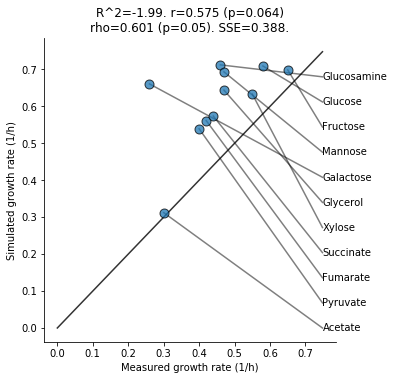

In [12]:
g = plot_growth(df_growth)

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

g.savefig('figures/schmidt_growth_validation1.pdf')
g.savefig('figures/schmidt_growth_validation1.svg')
g.savefig('figures/schmidt_growth_validation1.png', dpi=500)

# 3. Simulate protein abundances

In [13]:
df_sim = simulate_proteome(pcfba, df_conds_nonchemo)

### Compare with measured protein abundances

In [14]:
df_sim.rename(columns={'Growth condition':'condition'}, inplace=True)
total_frac_sim = ProtGrams / 0.56
df_sim_mf = to_mass_frac(df_sim, total_frac=total_frac_sim)

In [15]:
df_meas_mf = df_meas[['Bnumber','mf','condition','Growth rate (h-1)']].drop_duplicates()
TOTAL_FRAC_MEAS = 0.95
df_meas_mf.mf = df_meas_mf.mf * TOTAL_FRAC_MEAS
df_meas_mf.rename(columns={'Bnumber':'locus'}, inplace=True)

In [16]:
df_val = pd.merge(df_sim_mf.rename(columns={'mf':'Simulated'}),
                  df_meas_mf.rename(columns={'mf':'Measured'}), on=['condition','locus'])

## Compare protein abundance at the COG-level

In [17]:
def group_genes(df_locus, df_group, col_group, col_cond='condition', col_locus='locus'):
    df_coarse = pd.merge(df_locus, df_group, on=col_locus)
    df_coarse = df_coarse.groupby([col_cond,col_group]).mf.sum().reset_index()
    return df_coarse

def plot_by_group(df_sim, df_meas, df_group, col_group, col_cond='condition', col_locus='locus',
                 hue=None, col=None, col_wrap=5):
    if hue is None:
        hue = col_group
    if col is None:
        col = col_cond
    
    df_sim_group = group_genes(df_sim, df_group, col_group, col_cond, col_locus)
    df_meas_group = group_genes(df_meas, df_group, col_group, col_cond, col_locus)
    df_val = pd.merge(df_sim_group.rename(columns={'mf':'Simulated'}),
                      df_meas_group.rename(columns={'mf':'Measured'}),
                      on=[col_cond, col_group])
    
    ncols = len(df_val[hue].unique())
    palette = sns.color_palette('nipy_spectral', ncols)
    if col == 'collapse':

        g = sns.FacetGrid(df_val, hue=hue, size=5, aspect=1, palette=palette)
    else:                
        g = sns.FacetGrid(df_val, col=col, hue=hue, col_wrap=col_wrap, size=3, sharex=False, sharey=False, aspect=1,
                         palette=palette)
    
    g.map(plt.scatter, 'Measured', 'Simulated', edgecolor='#222222', lw=0.5, alpha=0.8, s=36)
    
    #g = sns.lmplot('Measured','Simulated', df_val, col=col_cond, col_wrap=5, size=3, sharey=False)    
    for ax in g.axes.flat:
        if col == 'collapse':
            dfi = df_val
            r,p = stats.pearsonr(dfi.Measured, dfi.Simulated)
            rho,prho = stats.spearmanr(dfi.Measured, dfi.Simulated)
            sse = sum((dfi.Simulated - dfi.Measured)**2)
            ax.set_title("r=%.3g (p=%.2g)\n rho=%.3g (p=%.2g).sse=%.3g" % (
                r,p,rho,prho,sse), size=10)
            xymax = max(dfi.Measured.max(), dfi.Simulated.max())*1.05
            ax.plot([0,xymax],[0,xymax], color='#333333', zorder=1, lw=1)
            xymin = -5e-2*xymax
            ax.set(xlim=[xymin,xymax], ylim=[xymin,xymax])
        else:
            cond = ax.get_title().replace('%s = '%col,'')
            dfi = df_val[ df_val[col]==cond]
            r,p = stats.pearsonr(dfi.Measured, dfi.Simulated)
            rho,prho = stats.spearmanr(dfi.Measured, dfi.Simulated)
            sse = sum((dfi.Simulated - dfi.Measured)**2)

            ax.set_title("%s. r=%.3g (p=%.2g)\n rho=%.3g (p=%.2g).sse=%.3g" % (
            cond, r,p,rho,prho,sse), size=10)
            xymax = max(dfi.Measured.max(), dfi.Simulated.max())*1.05
            ax.plot([0,xymax],[0,xymax], color='#333333', zorder=1, lw=1)
            xymin = -5e-2*xymax
            ax.set(xlim=[xymin,xymax], ylim=[xymin,xymax])
            
    if col == 'collapse':
        ax.legend(bbox_to_anchor=(1,1))
    else:
        ax.legend(bbox_to_anchor=(1,1), ncol=2)
    
    return g, df_val

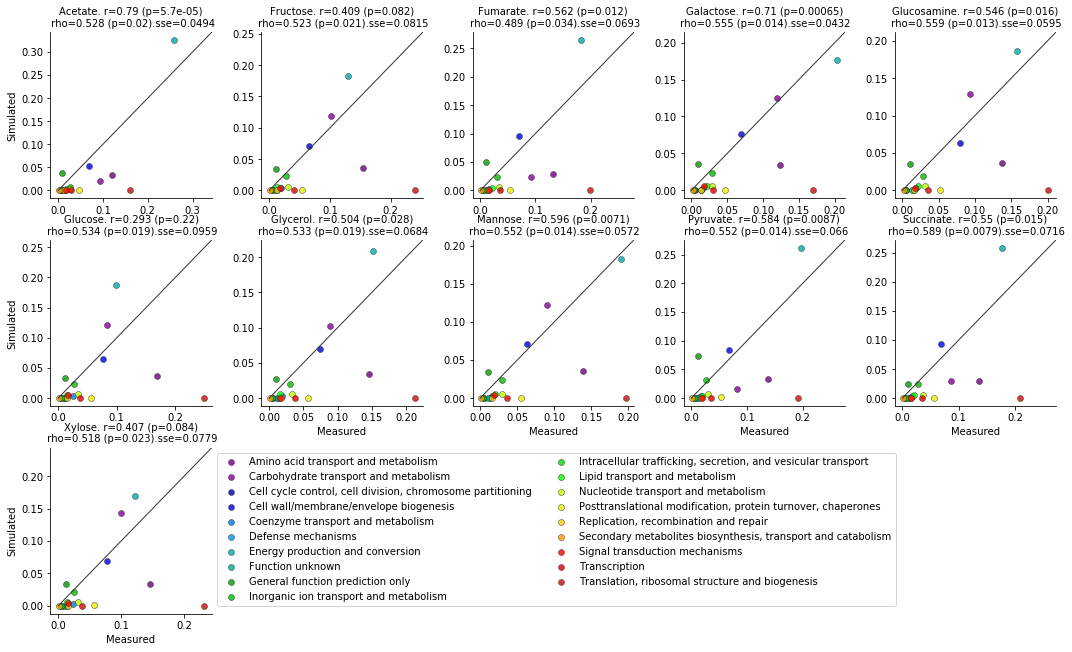

In [18]:
df_cog = pd.read_csv('../data/cogs_ecoli_mg1655.csv')
col_group = 'COG description'
df_cog_locus = df_cog[['locus',col_group]].drop_duplicates()

g,df_val_cog = plot_by_group(df_sim_mf, df_meas_mf, df_cog_locus, col_group=col_group, col='condition', hue=col_group)

In [19]:
# import matplotlib.pyplot as plt
# plt.rcParams['svg.fonttype'] = 'none'

# g.savefig('figures/proteome_validation1_cond.pdf')
# g.savefig('figures/proteome_validation1_cond.svg')
# g.savefig('figures/proteome_validation1_cond.png', dpi=500)

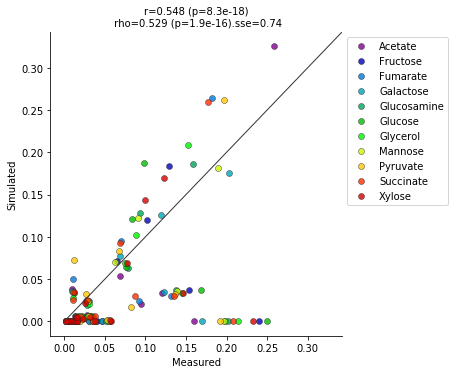

In [20]:
col_group = 'COG description'
df_cog_locus = df_cog[['locus',col_group]].drop_duplicates()

g,df_val_cog = plot_by_group(df_sim_mf, df_meas_mf, df_cog_locus, col_group=col_group, col='collapse', hue='condition')

In [21]:
# import matplotlib.pyplot as plt
# plt.rcParams['svg.fonttype'] = 'none'

# g.savefig('figures/proteome_validation1_cond_summ.pdf')
# g.savefig('figures/proteome_validation1_cond_summ.svg')
# g.savefig('figures/proteome_validation1_cond_summ.png', dpi=500)

## Summary view

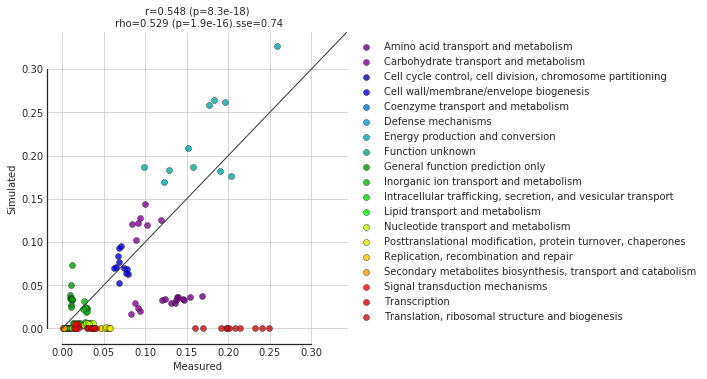

In [22]:
col_group = 'COG description'
df_cog_locus = df_cog[['locus',col_group]].drop_duplicates()

sns.set_style('white', {'axes.grid':True})
g,df_val_cog = plot_by_group(df_sim_mf, df_meas_mf, df_cog_locus, col_group=col_group, col='collapse', hue=col_group)
g.despine(trim=True, offset=1)

In [23]:
# import matplotlib.pyplot as plt
# plt.rcParams['svg.fonttype'] = 'none'

# g.savefig('figures/proteome_validation_summ1_norm.pdf')
# g.savefig('figures/proteome_validation_summ1_norm.svg')
# g.savefig('figures/proteome_validation_summ1_norm.png', dpi=500)

## 4. Reproduce characteristics

In [24]:
col_group = 'COG description'
df_cog_locus = df_cog[['locus',col_group]].drop_duplicates()

df_sim_cog = group_genes(df_sim_mf, df_cog_locus, col_group)
df_sim_mu_cog = pd.merge(df_sim_cog, df_growth[['Growth condition','Simulated']].rename(
columns={'Growth condition':'condition', 'Simulated':'mu'}), on='condition')
df_sim_mu_cog.loc[:,'source'] = 'Simulated'

In [25]:
df_meas_cog = group_genes(df_meas_mf, df_cog_locus, col_group)
df_meas_mu_cog = pd.merge(df_meas_cog, df_growth[['Growth condition','Measured']].rename(
columns={'Growth condition':'condition', 'Measured':'mu'}), on='condition')
df_meas_mu_cog.loc[:,'source'] = 'Measured'

In [26]:
df_val_mu_cog = pd.concat([df_sim_mu_cog, df_meas_mu_cog])

In [27]:
from sklearn import linear_model

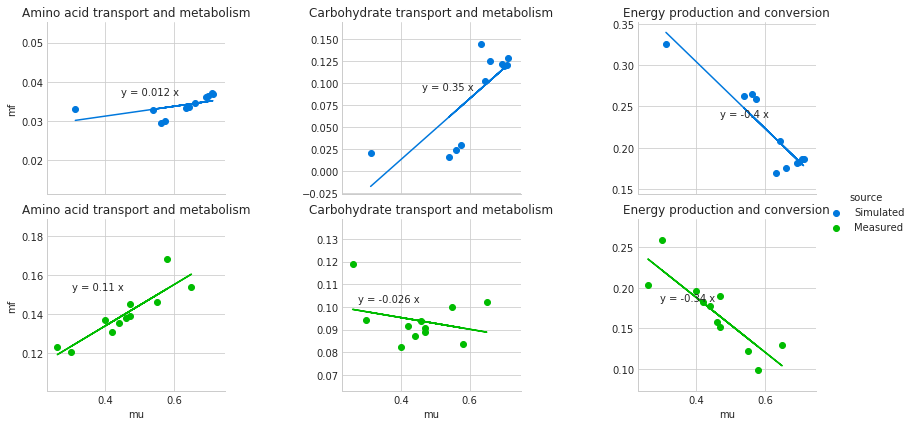

In [28]:
sns.set_style('whitegrid')

conditions = df_val_mu_cog.condition.unique()
sources    = df_val_mu_cog.source.unique().tolist()
n_conds = len(conditions)
n_srcs  = len(sources)
palette = sns.color_palette('nipy_spectral', n_colors=n_srcs+1)
df_val_mu_cog.loc[:,'COG'] = df_val_mu_cog[col_group]
cogs_interest = ['Amino acid transport and metabolism', 'Carbohydrate transport and metabolism',
                'Energy production and conversion']
dsplot = df_val_mu_cog[ df_val_mu_cog[col_group].isin(cogs_interest)]
g = sns.FacetGrid(dsplot, col='COG', row='source', size=3,
                  aspect=1.3, hue='source', sharey=False, palette=palette)
g.map(plt.scatter, 'mu','mf')

for ax in g.axes.flat:
    parts = ax.get_title().split('|')
    source = parts[0].replace('source = ','').strip()
    cog = parts[1].replace('COG = ','').strip()
    dfij = dsplot[ (dsplot['COG']==cog) & (dsplot['source']==source)]
    lm = linear_model.LinearRegression()
    x = dfij.mu.values
    X = x.reshape(len(x),1)
    y = dfij.mf.values.T
    lm.fit(X,y)
    yp = lm.predict(X)
    ax.plot(x,yp, color=palette[sources.index(source)])
    ax.text(np.mean(x), np.mean(yp)*1.1, "y = %.2g x"%lm.coef_[0], ha='right',va='center')
    ax.set_title("%s" % cog)
    
g.add_legend()

In [29]:
# import matplotlib.pyplot as plt
# plt.rcParams['svg.fonttype'] = 'none'

# g.savefig('figures/cog_trends.pdf')
# g.savefig('figures/cog_trends.svg')
# g.savefig('figures/cog_trends.png', dpi=500)

### Other COGs

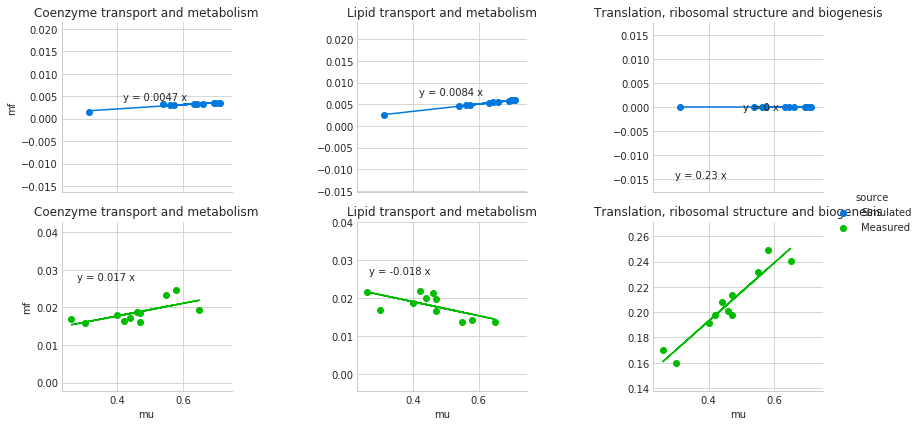

In [30]:
sns.set_style('whitegrid')

conditions = df_val_mu_cog.condition.unique()
sources    = df_val_mu_cog.source.unique().tolist()
n_conds = len(conditions)
n_srcs  = len(sources)
palette = sns.color_palette('nipy_spectral', n_colors=n_srcs+1)
df_val_mu_cog.loc[:,'COG'] = df_val_mu_cog[col_group]
cogs_interest = ['Coenzyme transport and metabolism','Translation, ribosomal structure and biogenesis',
                'Lipid transport and metabolism']
dsplot = df_val_mu_cog[ df_val_mu_cog[col_group].isin(cogs_interest)]
g = sns.FacetGrid(dsplot, col='COG', row='source', size=3,
                  aspect=1.3, hue='source', sharey=False, palette=palette)
g.map(plt.scatter, 'mu','mf')

for ax in g.axes.flat:
    parts = ax.get_title().split('|')
    source = parts[0].replace('source = ','').strip()
    cog = parts[1].replace('COG = ','').strip()
    dfij = dsplot[ (dsplot['COG']==cog) & (dsplot['source']==source)]
    lm = linear_model.LinearRegression()
    x = dfij.mu.values
    X = x.reshape(len(x),1)
    y = dfij.mf.values.T
    lm.fit(X,y)
    yp = lm.predict(X)
    ax.plot(x,yp, color=palette[sources.index(source)])
    ax.text(np.mean(x), np.mean(yp)*1.5, "y = %.2g x"%lm.coef_[0], ha='right',va='center')
    ax.set_title("%s" % cog)
    
g.add_legend()

In [31]:
# import matplotlib.pyplot as plt
# plt.rcParams['svg.fonttype'] = 'none'

# g.savefig('figures/cog_trends2.pdf')
# g.savefig('figures/cog_trends2.svg')
# g.savefig('figures/cog_trends2.png', dpi=500)

## Overflow metabolism

In [32]:
df_map = pd.read_csv('../data/gene_locus_map.csv')

/usr/lib/python2.7/site-packages/scipy/stats/stats.py:3003 RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python2.7/site-packages/numpy/lib/function_base.py:3183 RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python2.7/site-packages/numpy/lib/function_base.py:3184 RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879 RuntimeWarning: invalid value encountered in greater
/usr/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879 RuntimeWarning: invalid value encountered in less
/usr/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1821 RuntimeWarning: invalid value encountered in less_equal


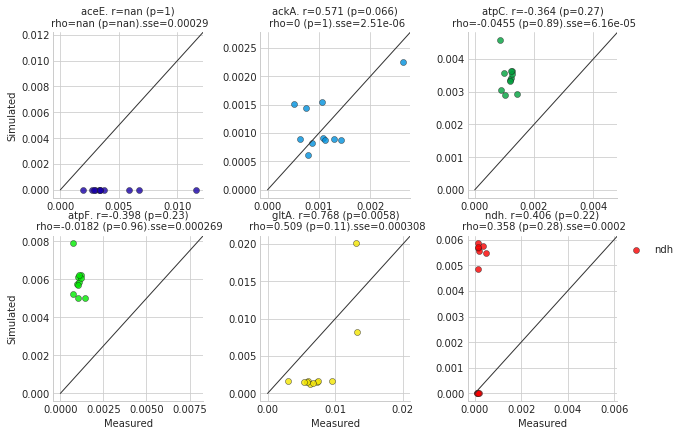

In [33]:
genes_plot = ['atpC','aceE','gltA', 'ackA','atpF','ndh']
dsplot = pd.merge(df_val, df_map, on='locus', how='left')
dsplot = dsplot[ dsplot.gene.isin(genes_plot)]

df_overflow = df_map[ df_map.gene.isin(genes_plot)]

g, df_val_over = plot_by_group(df_sim_mf, df_meas_mf, df_overflow, col_group='gene', col='gene', col_wrap=3)

In [34]:
# import matplotlib.pyplot as plt
# plt.rcParams['svg.fonttype'] = 'none'

# g.savefig('figures/protein_overflow.pdf')
# g.savefig('figures/protein_overflow.svg')
# g.savefig('figures/protein_overflow.png', dpi=500)